In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
import whisper
import speech_recognition as sr
import warnings
warnings.filterwarnings('ignore')

## STEP 1: DATA LOADING AND EXPLORATION 

In [3]:
print("🔍 STEP 1: Loading and Exploring the Dataset")
print("=" * 60)

def load_dataset(file_path=None):
    """
    Load the interview dataset from CSV file or create sample data
    
    Args:
        file_path (str): Path to CSV file (optional)
    
    Returns:
        pandas.DataFrame: Loaded dataset
    """
    if file_path:
        df = pd.read_csv(file_path,engine='python')
    else:
      
        data = {
            'audio_id': ['audio_01', 'audio_02', 'audio_03'],
            'question': ['Tell me about yourself', 'What are your strengths?', 'Why should we hire you?'],
            'enhanced_transcript': [
                'Hi um I am a computer science student [PAUSE:4.0s] I love coding and uh building applications',
                'I think my strength is problem solving and uh teamwork you know',
                'Because [PAUSE:3.0s] I believe my skills um fit the role perfectly'
            ],
            'filler_words': ['um,uh', 'uh,you know', 'um'],
            'filler_count': [2, 2, 1],
            'pause_locations': ['middle', 'none', 'beginning'],
            'pause_count': [1, 0, 1],
            'total_pause_time': [4.0, 0.0, 3.0],
            'word_count': [16, 12, 11],
            'speech_rate': [90, 135, 105],
            'fluency_score': [0.6, 0.8, 0.7]
        }
        df = pd.DataFrame(data)
    
    return df

# Load your dataset (replace with your actual CSV file path)
df = load_dataset("claude_dataset.csv")  # Replace with actual path


🔍 STEP 1: Loading and Exploring the Dataset


##  STEP 2: Advanced Feature Engineering

In [4]:
print("\n🔧 STEP 2: Advanced Feature Engineering")
print("=" * 60)

class InterviewFeatureExtractor:
    """
    Extract comprehensive features from interview transcripts for fluency analysis
    """
    
    def __init__(self):
        self.filler_patterns = r'\b(um|uh|er|ah|you know|like|actually|basically)\b'
        self.pause_pattern = r'\[PAUSE:(\d+\.?\d*)s\]'
    
    def extract_features(self, df):
        """
        Extract all features needed for fluency prediction
        
        Args:
            df (DataFrame): Input dataset
            
        Returns:
            DataFrame: Dataset with additional engineered features
        """
        print("Extracting advanced features...")
        
        # Create a copy to avoid modifying original data
        feature_df = df.copy()
        
        # 1. Basic derived features
        feature_df['filler_density'] = feature_df['filler_count'] / feature_df['word_count']
        feature_df['pause_density'] = feature_df['pause_count'] / feature_df['word_count']
        
        # 2. Pause-related features
        feature_df['avg_pause_duration'] = feature_df.apply(
            lambda row: row['total_pause_time'] / max(row['pause_count'], 1), axis=1
        )
        feature_df['has_long_pauses'] = (feature_df['total_pause_time'] > 3.0).astype(int)
        feature_df['has_multiple_pauses'] = (feature_df['pause_count'] > 1).astype(int)
        
        # 3. Speech rate categories
        feature_df['speech_rate_category'] = pd.cut(
            feature_df['speech_rate'], 
            bins=[0, 100, 120, 150, 300], 
            labels=['slow', 'normal', 'fast', 'very_fast']
        )
        
        # 4. Filler type diversity
        feature_df['filler_type_count'] = feature_df['filler_words'].apply(
            lambda x: len(x.split(',')) if pd.notna(x) and x != '' else 0
        )
        
        # 5. Response length categories
        feature_df['response_length_category'] = pd.cut(
            feature_df['word_count'],
            bins=[0, 10, 15, 20, 100],
            labels=['very_short', 'short', 'medium', 'long']
        )
        
        # 6. Composite features
        feature_df['hesitation_score'] = (
            feature_df['filler_density'] * 0.4 + 
            feature_df['pause_density'] * 0.3 + 
            feature_df['has_long_pauses'] * 0.3
        )
        
        # 7. Speech efficiency
        feature_df['speech_efficiency'] = feature_df['word_count'] / (
            feature_df['word_count'] + feature_df['filler_count'] + feature_df['pause_count']
        )
        
        print(f"✅ Feature extraction complete! Added {len(feature_df.columns) - len(df.columns)} new features")
        return feature_df




🔧 STEP 2: Advanced Feature Engineering


In [5]:
# Apply feature engineering
feature_extractor = InterviewFeatureExtractor()
df_features = feature_extractor.extract_features(df)

print("\nNew features created:")
new_features = set(df_features.columns) - set(df.columns)
for feature in new_features:
    print(f"  - {feature}")

Extracting advanced features...
✅ Feature extraction complete! Added 10 new features

New features created:
  - response_length_category
  - has_long_pauses
  - filler_type_count
  - speech_rate_category
  - pause_density
  - speech_efficiency
  - hesitation_score
  - filler_density
  - has_multiple_pauses
  - avg_pause_duration


In [6]:
df_features

,audio_id,question,enhanced_transcript,filler_words,filler_count,pause_locations,pause_count,total_pause_time,word_count,speech_rate,...,filler_density,pause_density,avg_pause_duration,has_long_pauses,has_multiple_pauses,speech_rate_category,filler_type_count,response_length_category,hesitation_score,speech_efficiency
0,audio_01,Tell me about yourself,Hi um I am a computer science student [PAUSE:4...,"um,uh",2,middle,1,4.0,16,90,...,0.125000,0.062500,4.00,1,0,slow,2,medium,0.368750,0.842105
1,audio_02,What are your strengths?,I think my strength is problem solving and uh ...,"uh,you know",2,none,0,0.0,12,135,...,0.166667,0.000000,0.00,0,0,fast,2,short,0.066667,0.857143
2,audio_03,Why should we hire you?,Because [PAUSE:3.0s] I believe my skills um fi...,um,1,beginning,1,3.0,11,105,...,0.090909,0.090909,3.00,0,0,normal,1,short,0.063636,0.846154
3,audio_04,Describe a challenging project,Well uh [PAUSE:2.0s] there was this project wh...,"uh,um,you know",3,"beginning,middle",2,3.5,16,85,...,0.187500,0.125000,1.75,1,1,slow,3,medium,0.412500,0.761905
4,audio_05,Where do you see yourself in 5 years?,In five years I see myself as uh a senior deve...,uh,1,none,0,0.0,16,125,...,0.062500,0.000000,0.00,0,0,fast,1,medium,0.025000,0.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,audio_146,How do you handle technical presentations?,I handle presentations by um preparing clear s...,"um,uh,you know",3,none,0,0.0,13,110,...,0.230769,0.000000,0.00,0,0,normal,3,short,0.092308,0.812500
146,audio_147,What's your approach to capacity planning?,My approach involves um analyzing usage patter...,"um,uh",2,middle,1,1.8,13,108,...,0.153846,0.076923,1.80,0,0,normal,2,short,0.084615,0.812500
147,audio_148,How do you ensure reliable deployments?,I ensure reliability by um using blue-green de...,"um,uh",2,none,0,0.0,13,125,...,0.153846,0.000000,0.00,0,0,fast,2,short,0.061538,0.866667
148,audio_149,What's your experience with edge computing?,I have experience with um CDN edge functions a...,"um,uh",2,middle,1,2.1,13,105,...,0.153846,0.076923,2.10,0,0,normal,2,short,0.084615,0.812500


## STEP 3: Data Visualization and Analysis


📊 STEP 3: Data Visualization and Analysis


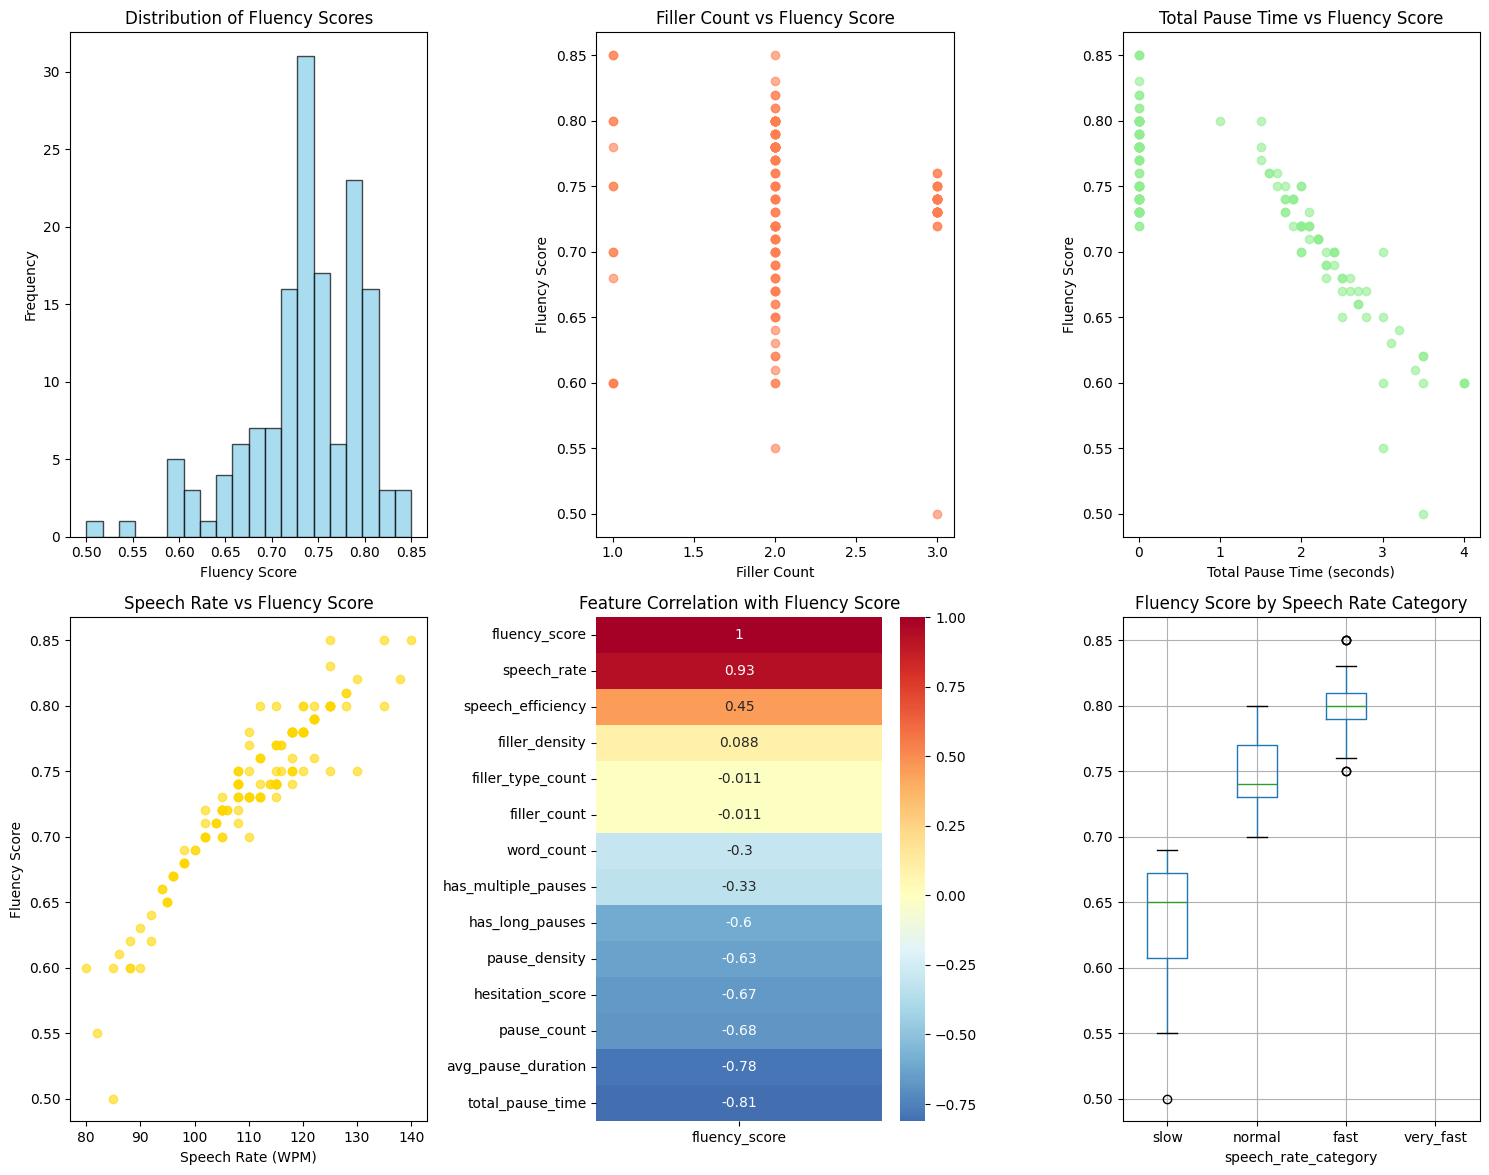

In [7]:
print("\n📊 STEP 3: Data Visualization and Analysis")
print("=" * 60)

def visualize_data(df):
    """
    Create comprehensive visualizations of the interview data
    """
    plt.figure(figsize=(15, 12))
    
    # 1. Fluency score distribution
    plt.subplot(2, 3, 1)
    plt.hist(df['fluency_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Fluency Scores')
    plt.xlabel('Fluency Score')
    plt.ylabel('Frequency')
    
    # 2. Filler count vs Fluency
    plt.subplot(2, 3, 2)
    plt.scatter(df['filler_count'], df['fluency_score'], alpha=0.6, color='coral')
    plt.title('Filler Count vs Fluency Score')
    plt.xlabel('Filler Count')
    plt.ylabel('Fluency Score')
    
    # 3. Pause time vs Fluency
    plt.subplot(2, 3, 3)
    plt.scatter(df['total_pause_time'], df['fluency_score'], alpha=0.6, color='lightgreen')
    plt.title('Total Pause Time vs Fluency Score')
    plt.xlabel('Total Pause Time (seconds)')
    plt.ylabel('Fluency Score')
    
    # 4. Speech rate vs Fluency
    plt.subplot(2, 3, 4)
    plt.scatter(df['speech_rate'], df['fluency_score'], alpha=0.6, color='gold')
    plt.title('Speech Rate vs Fluency Score')
    plt.xlabel('Speech Rate (WPM)')
    plt.ylabel('Fluency Score')
    
    # 5. Feature correlation heatmap
    plt.subplot(2, 3, 5)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix[['fluency_score']].sort_values('fluency_score', ascending=False), 
                annot=True, cmap='RdYlBu_r', center=0)
    plt.title('Feature Correlation with Fluency Score')
    
    # 6. Fluency by speech rate category
    plt.subplot(2, 3, 6)
    if 'speech_rate_category' in df.columns:
        df.boxplot(column='fluency_score', by='speech_rate_category', ax=plt.gca())
        plt.title('Fluency Score by Speech Rate Category')
        plt.suptitle('')  # Remove default title
    
    plt.tight_layout()
    plt.show()

# Visualize the data
visualize_data(df_features)




In [8]:
# Print key statistics
print("\n📈 Key Dataset Statistics:")
print(f"Average fluency score: {df_features['fluency_score'].mean():.3f}")
print(f"Fluency score std: {df_features['fluency_score'].std():.3f}")
print(f"Average fillers per response: {df_features['filler_count'].mean():.2f}")
print(f"Average pauses per response: {df_features['pause_count'].mean():.2f}")
print(f"Average speech rate: {df_features['speech_rate'].mean():.1f} WPM")


📈 Key Dataset Statistics:
Average fluency score: 0.736
Fluency score std: 0.059
Average fillers per response: 2.13
Average pauses per response: 0.46
Average speech rate: 110.9 WPM


## STEP 4: Preparing Data for Model Training

In [9]:
print("\n🎯 STEP 4: Preparing Data for Model Training")
print("=" * 60)

def prepare_model_data(df):
    """
    Prepare features and target variables for machine learning
    
    Args:
        df (DataFrame): Feature-engineered dataset
        
    Returns:
        tuple: X_train, X_test, y_train, y_test, feature_names, scaler
    """
    print("Preparing features for model training...")
    
    # Select features for training (exclude non-numeric and target columns)
    feature_columns = [
        'filler_count', 'pause_count', 'total_pause_time', 'word_count', 'speech_rate',
        'filler_density', 'pause_density', 'avg_pause_duration', 'has_long_pauses',
        'has_multiple_pauses', 'filler_type_count', 'hesitation_score', 'speech_efficiency'
    ]
    
    # Ensure all feature columns exist
    available_features = [col for col in feature_columns if col in df.columns]
    print(f"Using {len(available_features)} features: {available_features}")
    
    # Prepare feature matrix X and target vector y
    X = df[available_features].copy()
    y = df['fluency_score'].copy()
    
    # Handle any missing values
    X = X.fillna(0)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=3)
    )
    
    # Scale features for better model performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"✅ Data preparation complete!")
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Feature dimensions: {X_train.shape[1]} features")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, available_features, scaler




🎯 STEP 4: Preparing Data for Model Training


In [10]:
# Prepare the data
X_train, X_test, y_train, y_test, feature_names, scaler = prepare_model_data(df_features)

Preparing features for model training...
Using 13 features: ['filler_count', 'pause_count', 'total_pause_time', 'word_count', 'speech_rate', 'filler_density', 'pause_density', 'avg_pause_duration', 'has_long_pauses', 'has_multiple_pauses', 'filler_type_count', 'hesitation_score', 'speech_efficiency']
✅ Data preparation complete!
Training set size: 120 samples
Test set size: 30 samples
Feature dimensions: 13 features


## STEP 5: MODEL TRAINING AND COMPARISON 

In [11]:



print("\n🤖 STEP 5: Training Multiple Models")
print("=" * 60)

class ModelTrainer:
    """
    Train and compare multiple regression models for fluency prediction
    """
    
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def train_models(self, X_train, X_test, y_train, y_test):
        """
        Train multiple models and compare their performance
        """
        print("Training multiple models...")
        
        # Define models to train
        model_configs = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }
        
        # Train each model
        for name, model in model_configs.items():
            print(f"\nTraining {name}...")
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Calculate metrics
            train_mse = mean_squared_error(y_train, y_pred_train)
            test_mse = mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # Cross-validation score
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
            
            # Store results
            self.models[name] = model
            self.results[name] = {
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'test_mae': test_mae,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'predictions': y_pred_test
            }
            
            print(f"  ✅ {name} trained successfully!")
            print(f"     Test R² Score: {test_r2:.4f}")
            print(f"     Test MAE: {test_mae:.4f}")
            print(f"     CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        
        return self.models, self.results
    
    def print_comparison(self):
        """
        Print detailed comparison of all models
        """
        print("\n📊 MODEL PERFORMANCE COMPARISON")
        print("=" * 80)
        print(f"{'Model':<18} {'Test R²':<10} {'Test MAE':<10} {'CV Score':<15} {'Overfitting':<12}")
        print("-" * 80)
        
        for name, results in self.results.items():
            overfitting = results['train_r2'] - results['test_r2']
            print(f"{name:<18} {results['test_r2']:<10.4f} {results['test_mae']:<10.4f} "
                  f"{results['cv_mean']:<7.4f}±{results['cv_std']:<7.4f} {overfitting:<12.4f}")
    
    def get_best_model(self):
        """
        Return the best performing model based on test R² score
        """
        best_name = max(self.results.keys(), key=lambda x: self.results[x]['test_r2'])
        return best_name, self.models[best_name], self.results[best_name]





🤖 STEP 5: Training Multiple Models


In [12]:
# Train models
trainer = ModelTrainer()
models, results = trainer.train_models(X_train, X_test, y_train, y_test)
trainer.print_comparison()

# Get best model
best_model_name, best_model, best_results = trainer.get_best_model()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R² Score: {best_results['test_r2']:.4f}")
print(f"   Test MAE: {best_results['test_mae']:.4f}")

Training multiple models...

Training Linear Regression...
  ✅ Linear Regression trained successfully!
     Test R² Score: 0.9039
     Test MAE: 0.0108
     CV Score: 0.9102 (±0.0899)

Training Random Forest...
  ✅ Random Forest trained successfully!
     Test R² Score: 0.8809
     Test MAE: 0.0110
     CV Score: 0.9128 (±0.0586)

Training Gradient Boosting...
  ✅ Gradient Boosting trained successfully!
     Test R² Score: 0.8747
     Test MAE: 0.0111
     CV Score: 0.9066 (±0.0597)

📊 MODEL PERFORMANCE COMPARISON
Model              Test R²    Test MAE   CV Score        Overfitting 
--------------------------------------------------------------------------------
Linear Regression  0.9039     0.0108     0.9102 ±0.0899  0.0713      
Random Forest      0.8809     0.0110     0.9128 ±0.0586  0.1046      
Gradient Boosting  0.8747     0.0111     0.9066 ±0.0597  0.1201      

🏆 Best Model: Linear Regression
   Test R² Score: 0.9039
   Test MAE: 0.0108


## STEP 6: Hyperparameter Tuning

In [13]:
print("\n⚙️  STEP 6: Hyperparameter Tuning")
print("=" * 60)

def tune_best_model(model, X_train, y_train):
    """
    Perform hyperparameter tuning on the best model
    """
    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
    else:
        # For Linear Regression, no hyperparameters to tune
        return model
    
    print(f"Tuning {best_model_name} hyperparameters...")
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"✅ Best parameters: {grid_search.best_params_}")
    print(f"✅ Best CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Tune the best model
print(f"Tuning {best_model_name}...")
tuned_model = tune_best_model(best_model, X_train, y_train)

# Evaluate tuned model
y_pred_tuned = tuned_model.predict(X_test)
tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

print(f"\n📈 TUNED MODEL PERFORMANCE:")
print(f"   Test R² Score: {tuned_r2:.4f} (improvement: {tuned_r2 - best_results['test_r2']:+.4f})")
print(f"   Test MAE: {tuned_mae:.4f} (improvement: {best_results['test_mae'] - tuned_mae:+.4f})")



⚙️  STEP 6: Hyperparameter Tuning
Tuning Linear Regression...

📈 TUNED MODEL PERFORMANCE:
   Test R² Score: 0.9039 (improvement: +0.0000)
   Test MAE: 0.0108 (improvement: +0.0000)


## STEP 7: Feature Importance Analysis

In [14]:
print("\n🔍 STEP 7: Feature Importance Analysis")
print("=" * 60)

def analyze_feature_importance(model, feature_names):
    """
    Analyze and visualize feature importance
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Create feature importance DataFrame
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("📊 FEATURE IMPORTANCE RANKING:")
        print("-" * 40)
        for idx, row in feature_importance_df.iterrows():
            print(f"{row['feature']:<20}: {row['importance']:.4f}")
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
        plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance in Fluency Prediction')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return feature_importance_df
    else:
        print("Model doesn't support feature importance analysis")
        return None



🔍 STEP 7: Feature Importance Analysis


In [15]:

# Analyze feature importance
feature_importance = analyze_feature_importance(tuned_model, feature_names)

Model doesn't support feature importance analysis


## STEP 8: Saving the Trained Model

In [16]:
print("\n💾 STEP 8: Saving the Trained Model")
print("=" * 60)

def save_model_pipeline(model, scaler, feature_names, model_name):
    """
    Save the complete model pipeline for deployment
    """
    model_package = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names,
        'model_name': model_name,
        'performance_metrics': {
            'test_r2': tuned_r2,
            'test_mae': tuned_mae
        }
    }
    
    # Save the complete pipeline
    model_filename = f'fluency_predictor_{model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model_package, model_filename)
    
    print(f"✅ Model pipeline saved as: {model_filename}")
    return model_filename




💾 STEP 8: Saving the Trained Model


In [17]:
# Save the trained model
model_filename = save_model_pipeline(tuned_model, scaler, feature_names, best_model_name)

✅ Model pipeline saved as: fluency_predictor_linear_regression.pkl


## STEP 9: Creating Inference Pipeline

In [18]:
# ==================== STEP 9: INFERENCE PIPELINE ====================
print("\n🚀 STEP 9: Creating Inference Pipeline")
print("=" * 60)

class FluentInterviewAnalyzer:
    """
    Complete pipeline for analyzing interview fluency from audio or transcript
    """
    
    def __init__(self, model_path):
        """
        Load the trained model and initialize the analyzer
        """
        self.model_package = joblib.load(model_path)
        self.model = self.model_package['model']
        self.scaler = self.model_package['scaler']
        self.feature_names = self.model_package['feature_names']
        self.filler_patterns = r'\b(um|uh|er|ah|you know|like|actually|basically)\b'
        self.pause_pattern = r'\[PAUSE:(\d+\.?\d*)s\]'
        
        print(f"✅ Fluency analyzer loaded successfully!")
        print(f"   Model: {self.model_package['model_name']}")
        print(f"   Test R² Score: {self.model_package['performance_metrics']['test_r2']:.4f}")
    
    def analyze_transcript(self, enhanced_transcript):
        """
        Analyze fluency from an enhanced transcript with pause markers
        
        Args:
            enhanced_transcript (str): Transcript with [PAUSE:Xs] markers
            
        Returns:
            dict: Analysis results including fluency score and breakdown
        """
        # Extract basic features
        filler_matches = re.findall(self.filler_patterns, enhanced_transcript, re.IGNORECASE)
        pause_matches = re.findall(self.pause_pattern, enhanced_transcript)
        
        filler_count = len(filler_matches)
        pause_count = len(pause_matches)
        total_pause_time = sum(float(p) for p in pause_matches)
        
        # Clean transcript for word count
        clean_text = re.sub(self.pause_pattern, '', enhanced_transcript)
        clean_text = re.sub(self.filler_patterns, '', clean_text, re.IGNORECASE)
        word_count = len(clean_text.split())
        
        # Calculate derived features
        filler_density = filler_count / max(word_count, 1)
        pause_density = pause_count / max(word_count, 1)
        avg_pause_duration = total_pause_time / max(pause_count, 1)
        has_long_pauses = int(total_pause_time > 3.0)
        has_multiple_pauses = int(pause_count > 1)
        
        # Estimate speech rate (approximate)
        estimated_speech_time = word_count / 2.0 + total_pause_time  # Rough estimate
        speech_rate = (word_count / estimated_speech_time) * 60 if estimated_speech_time > 0 else 120
        
        filler_type_count = len(set(filler_matches))
        hesitation_score = filler_density * 0.4 + pause_density * 0.3 + has_long_pauses * 0.3
        speech_efficiency = word_count / (word_count + filler_count + pause_count)
        
        # Create feature vector
        features = {
            'filler_count': filler_count,
            'pause_count': pause_count,
            'total_pause_time': total_pause_time,
            'word_count': word_count,
            'speech_rate': speech_rate,
            'filler_density': filler_density,
            'pause_density': pause_density,
            'avg_pause_duration': avg_pause_duration,
            'has_long_pauses': has_long_pauses,
            'has_multiple_pauses': has_multiple_pauses,
            'filler_type_count': filler_type_count,
            'hesitation_score': hesitation_score,
            'speech_efficiency': speech_efficiency
        }
        
        # Prepare for prediction
        feature_vector = [features.get(name, 0) for name in self.feature_names]
        feature_vector_scaled = self.scaler.transform([feature_vector])
        
        # Predict fluency
        fluency_score = self.model.predict(feature_vector_scaled)[0]
        fluency_score = max(0.0, min(1.0, fluency_score))  # Ensure valid range
        
        # Generate interpretation
        if fluency_score >= 0.8:
            fluency_level = "Excellent"
            interpretation = "Very fluent response with minimal hesitations"
        elif fluency_score >= 0.7:
            fluency_level = "Good"
            interpretation = "Generally fluent with some minor hesitations"
        elif fluency_score >= 0.6:
            fluency_level = "Fair"
            interpretation = "Moderate fluency with noticeable hesitations"
        else:
            fluency_level = "Poor"
            interpretation = "Low fluency with significant hesitations"
        
        return {
            'fluency_score': round(fluency_score, 3),
            'fluency_level': fluency_level,
            'interpretation': interpretation,
            'details': {
                'filler_count': filler_count,
                'filler_words': list(set(filler_matches)),
                'pause_count': pause_count,
                'total_pause_time': round(total_pause_time, 1),
                'word_count': word_count,
                'speech_rate': round(speech_rate, 1)
            },
            'recommendations': self._get_recommendations(features)
        }
    
    def _get_recommendations(self, features):
        """
        Generate personalized recommendations based on analysis
        """
        recommendations = []
        
        if features['filler_density'] > 0.1:
            recommendations.append("Practice reducing filler words like 'um' and 'uh' by pausing instead")
        
        if features['has_long_pauses']:
            recommendations.append("Work on reducing long pauses by preparing key points in advance")
        
        if features['speech_rate'] < 100:
            recommendations.append("Try to speak at a slightly faster pace to maintain engagement")
        elif features['speech_rate'] > 150:
            recommendations.append("Consider slowing down slightly for better clarity")
        
        if features['speech_efficiency'] < 0.8:
            recommendations.append("Practice speaking more concisely and directly")
        
        if not recommendations:
            recommendations.append("Great fluency! Continue practicing to maintain this level")
        
        return recommendations

# Create analyzer instance
analyzer = FluentInterviewAnalyzer(model_filename)


🚀 STEP 9: Creating Inference Pipeline
✅ Fluency analyzer loaded successfully!
   Model: Linear Regression
   Test R² Score: 0.9039


## STEP 10: Testing the Complete Pipeline

In [19]:
print("\n🧪 STEP 10: Testing the Complete Pipeline")
print("=" * 60)

# Test with sample transcripts
test_transcripts = [
    "Hi um I am a software developer [PAUSE:2.5s] I have five years of experience in uh web development",
    "I think my biggest strength is problem solving and you know working well in teams",
    "Well uh [PAUSE:3.5s] I believe that um [PAUSE:2.0s] my skills would be a good fit for uh this role"
]

for i, transcript in enumerate(test_transcripts, 1):
    print(f"\n--- TEST CASE {i} ---")
    print(f"Transcript: {transcript}")
    
    result = analyzer.analyze_transcript(transcript)
    
    print(f"Fluency Score: {result['fluency_score']} ({result['fluency_level']})")
    print(f"Interpretation: {result['interpretation']}")
    print(f"Details: {result['details']}")
    print(f"Recommendations: {'; '.join(result['recommendations'])}")

print(f"\n🎉 TRAINING PIPELINE COMPLETE!")
print(f"✅ Model trained and saved successfully")
print(f"✅ Inference pipeline ready for deployment")
print(f"✅ Model file: {model_filename}")



🧪 STEP 10: Testing the Complete Pipeline

--- TEST CASE 1 ---
Transcript: Hi um I am a software developer [PAUSE:2.5s] I have five years of experience in uh web development
Fluency Score: 0.647 (Fair)
Interpretation: Moderate fluency with noticeable hesitations
Details: {'filler_count': 2, 'filler_words': ['uh', 'um'], 'pause_count': 1, 'total_pause_time': 2.5, 'word_count': 15, 'speech_rate': 90.0}
Recommendations: Practice reducing filler words like 'um' and 'uh' by pausing instead; Try to speak at a slightly faster pace to maintain engagement

--- TEST CASE 2 ---
Transcript: I think my biggest strength is problem solving and you know working well in teams
Fluency Score: 0.808 (Excellent)
Interpretation: Very fluent response with minimal hesitations
Details: {'filler_count': 1, 'filler_words': ['you know'], 'pause_count': 0, 'total_pause_time': 0, 'word_count': 13, 'speech_rate': 120.0}
Recommendations: Great fluency! Continue practicing to maintain this level

--- TEST CASE 3 ---
T

In [20]:
# Load your trained model
analyzer = FluentInterviewAnalyzer('fluency_predictor_linear_regression.pkl')

# Give it ANY text - it handles the rest
result = analyzer.analyze_transcript(
    "Hello mynameismuthubani and[UH] asyouknow I'mtryingtobuildaproject.Youknow I'mfacingverymuchdifficultiesrightnow because [UH] inmymind there'salotofthingshappeningrightnow [UH]but Ithink so Icanovercomethat because Godisnmyside Iknow I'mjustmakingthisaudio to [UH]tryandtestmy. [PAUSE:3.3s] [PAUSE:2.9s] [UH] I'm. Don't."
)

# Get complete analysis
print(f"Fillers found: {result['details']['filler_words']}")  # ['um', 'uh']
print(f"Pause time: {result['details']['total_pause_time']}")  # 2.0 seconds
print(f"Fluency score: {result['fluency_score']}")  # 0.72
print(f"Recommendations: {result['recommendations']}")  # Specific advice

✅ Fluency analyzer loaded successfully!
   Model: Linear Regression
   Test R² Score: 0.9039
Fillers found: ['UH']
Pause time: 6.2
Fluency score: 0.307
Recommendations: ["Practice reducing filler words like 'um' and 'uh' by pausing instead", 'Work on reducing long pauses by preparing key points in advance', 'Try to speak at a slightly faster pace to maintain engagement', 'Practice speaking more concisely and directly']
